# Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from timeit import default_timer as timer
from datetime import datetime, date

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
def plot_multiclass_confusion_matrix(y_test, y_pred, categories):
    """Plots the confusion matrix given the data and the lables."""
    
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    stats_text = "\n\nAccuracy={:0.2f}%".format(100*np.trace(cm) / float(np.sum(cm)))
    
    box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    fig = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=box_labels, fmt='', cmap='Reds', xticklabels=categories, yticklabels=categories)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(stats_text)
    
    return fig, ax

In [3]:
# Define Search parameters
SCORING='precision'
# SCORING='roc_auc'
# SCORING='accuracy'
CV_FOLDS=3

N_ITER=10 #For Bayesian Search
N_POINTS=1 #For Bayesian Search



In [4]:
with open('../data/features.csv') as f1:
    df = pd.read_csv(f1)

with open('../data/outcomes.csv') as f2:
    outcomes = pd.read_csv(f2, usecols=['student_id', 'outcome'])
                           
df = pd.merge(df, outcomes, on='student_id')
 

df.drop(['Unnamed: 0', 'course_id'], axis='columns', inplace=True)
labels = ['fail', 'pass']
target_variable_name = 'outcome'
df.dropna(axis='index', how='any', subset=['outcome'], inplace=True)
df.outcome = df.outcome.astype(int)

In [5]:
df.head()

,student_id,tot_page_views,average_daily_views,median_daily_views,max_daily_views,days_with_views,hours_with_views,max_views_per_hour,avg_views_per_hour,median_views_per_hour,avg_hours_with_views_per_day,max_hours_with_views_per_day,median_hours_with_views_per_day,tot_participations,average_daily_participations,median_daily_participations,max_daily_participations,days_with_participations,outcome
0,47649,1153,22.607843,16.0,118.0,51,71,88.0,16.239437,15.0,1.392157,1.392157,1.0,23,0.460000,0.0,4.0,50,1
1,52263,744,15.183673,0.0,93.0,49,67,48.0,11.104478,8.0,1.367347,1.367347,0.0,20,0.434783,0.0,3.0,46,1
2,24036,341,6.686275,0.0,80.0,51,27,48.0,12.629630,11.0,0.529412,0.529412,0.0,15,0.333333,0.0,3.0,45,1
3,52137,237,5.042553,0.0,68.0,47,19,32.0,12.473684,9.0,0.404255,0.404255,0.0,6,0.187500,0.0,3.0,32,1
4,52267,665,13.300000,0.0,161.0,50,42,118.0,15.833333,8.0,0.840000,0.840000,0.0,26,0.520000,0.0,5.0,50,1


## Missing Values

Since there are only a few missing values we can simply discard them

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 424
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   student_id                       422 non-null    int64  
 1   tot_page_views                   422 non-null    int64  
 2   average_daily_views              419 non-null    float64
 3   median_daily_views               419 non-null    float64
 4   max_daily_views                  419 non-null    float64
 5   days_with_views                  422 non-null    int64  
 6   hours_with_views                 422 non-null    int64  
 7   max_views_per_hour               419 non-null    float64
 8   avg_views_per_hour               419 non-null    float64
 9   median_views_per_hour            419 non-null    float64
 10  avg_hours_with_views_per_day     419 non-null    float64
 11  max_hours_with_views_per_day     419 non-null    float64
 12  median_hours_with_view

In [7]:
df.dropna(axis='index', how='any', inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416 entries, 0 to 424
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   student_id                       416 non-null    int64  
 1   tot_page_views                   416 non-null    int64  
 2   average_daily_views              416 non-null    float64
 3   median_daily_views               416 non-null    float64
 4   max_daily_views                  416 non-null    float64
 5   days_with_views                  416 non-null    int64  
 6   hours_with_views                 416 non-null    int64  
 7   max_views_per_hour               416 non-null    float64
 8   avg_views_per_hour               416 non-null    float64
 9   median_views_per_hour            416 non-null    float64
 10  avg_hours_with_views_per_day     416 non-null    float64
 11  max_hours_with_views_per_day     416 non-null    float64
 12  median_hours_with_view

## Feature Selection


In [9]:
x = df.drop(['student_id','outcome'], axis='columns')
y = df['outcome'].values.reshape(-1,1)

In [10]:
x.shape, y.shape

((416, 17), (416, 1))

In [11]:
Min_Max = MinMaxScaler()
X = Min_Max.fit_transform(x)
Y= Min_Max.fit_transform(y)

# Split the data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((291, 17), (125, 17))

In [12]:
scores_df = pd.DataFrame()
# Create a naive random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train,np.ravel(Y_train), cv=CV_FOLDS, scoring=SCORING)

print("Naive Random Forest all features")
print(f"Mean Score: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Score: 0.8455571190327289 
Standard Deviation : 0.018073102207309618


In [13]:
scores_df = scores_df.append({'# features':'all',
               'Mean Score':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)

In [14]:
scores_df

,# features,Mean Score,Std
0,all,0.845557,0.018073


### Lasso

In [15]:
sel = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel.fit(X_train, np.ravel(Y_train))

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [16]:
print("Selected features :")
_ = [print(f"- {c}") for c in x.loc[:, sel.get_support()].columns]

Selected features :
- hours_with_views
- avg_views_per_hour
- tot_participations
- days_with_participations


In [17]:
X_train_df = pd.DataFrame(X_train)
selected_features = X_train_df.columns[(sel.get_support())]
print(f'total features: {(X_train_df.shape[1])}')
print(f'selected features: {len(selected_features)}')
print(f'features with coefficients shrank to zero: {np.sum(sel.estimator_.coef_ == 0)}')

total features: 17
selected features: 4
features with coefficients shrank to zero: 13


In [18]:
removed_features = X_train_df.columns[(sel.estimator_.coef_ == 0).ravel().tolist()]
removed_features

Int64Index([0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15], dtype='int64')

In [19]:
X_train_lasso_selected = sel.transform(X_train_df)
X_test_lasso_selected = sel.transform(X_test)

In [20]:
# Create a naive random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train_lasso_selected, np.ravel(Y_train), cv=CV_FOLDS, scoring=SCORING)

print("Naive Random Forest all features")
print(f"Mean Score: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Score: 0.8542565244569463 
Standard Deviation : 0.01476160599962281


In [21]:
scores_df = scores_df.append({'# features':'lasso',
               'Mean Score':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)
scores_df.head()

,# features,Mean Score,Std
0,all,0.845557,0.018073
1,lasso,0.854257,0.014762


### RFE

In [22]:
# Load/Run RFE
pkl_filename = f"../models/rfecv_{SCORING}.pkl"
try :
    # Load Model
    rfecv = pickle.load(open(pkl_filename, 'rb'))

except :
    # Perform RFE
    print('Training')
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(CV_FOLDS), scoring=SCORING)
    rfecv.fit(X_train, np.ravel(Y_train))
    # Save model
    with open(pkl_filename, 'wb') as file:
        pickle.dump(rfecv, file)

In [23]:
print(f'Optimal number of features: {rfecv.n_features_}')

Optimal number of features: 4


In [24]:
print("Selected features :")
_ = [print(f"- {c}") for c in x.loc[:, rfecv.support_].columns]

Selected features :
- days_with_views
- hours_with_views
- tot_participations
- days_with_participations


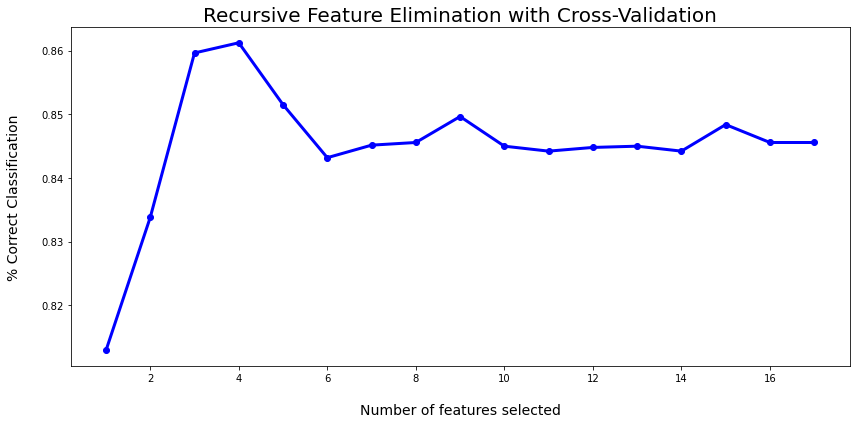

In [25]:
plt.figure(figsize=(12, 6))
plt.title(f'Recursive Feature Elimination with Cross-Validation', fontsize=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'bo-', linewidth=3)
plt.tight_layout()
plt.savefig(f"../figures/Recursive Feature Elimination with Cross-Validation - {SCORING}.png")
plt.show()

In [26]:
X_train_rfe_selected = rfecv.transform(X_train_df)
X_test_rfe_selected = rfecv.transform(X_test)

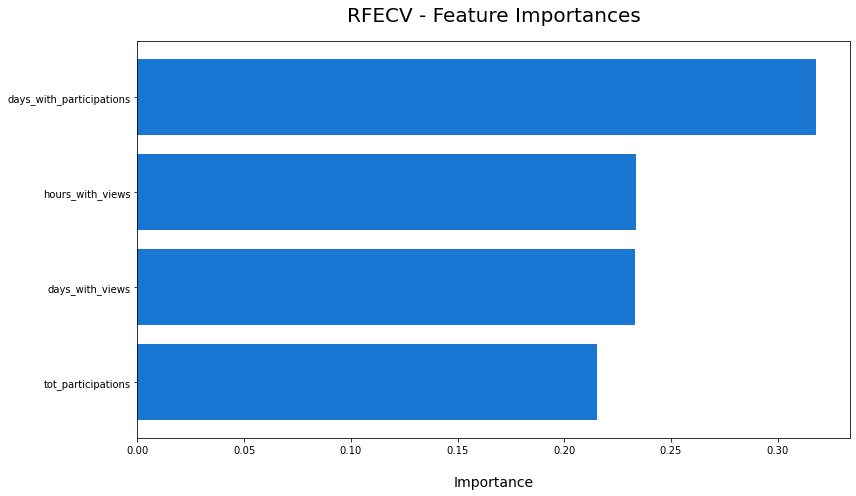

In [27]:
dset = pd.DataFrame()
dset['attr'] = x.loc[:, rfecv.support_].columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(12, 7))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.tight_layout()
plt.savefig(f"../figures/RFECV - Feature Importances - {SCORING}.png")
plt.show()

In [28]:
# Create a naive random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
cv_scores = cross_val_score(clf, X_train_rfe_selected, np.ravel(Y_train), cv=10)

print("Naive Random Forest all features")
print(f"Mean Score: {np.mean(cv_scores)} \nStandard Deviation : {np.std(cv_scores)}")

Naive Random Forest all features
Mean Score: 0.8317241379310346 
Standard Deviation : 0.06216085152686206


In [29]:
scores_df = scores_df.append({'# features':'rfe',
               'Mean Score':np.mean(cv_scores),
               'Std':np.std(cv_scores)}, ignore_index=True)
scores_df.head()

,# features,Mean Score,Std
0,all,0.845557,0.018073
1,lasso,0.854257,0.014762
2,rfe,0.831724,0.062161


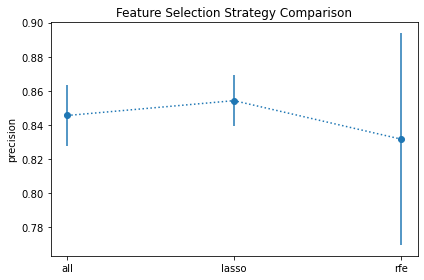

In [30]:
plt.errorbar(scores_df['# features'], scores_df['Mean Score'], yerr=scores_df['Std'], fmt="o:")
plt.title('Feature Selection Strategy Comparison')
plt.ylabel(f'{SCORING}')
plt.tight_layout()
plt.savefig(f"../figures/Feature Selection Strategy Comparison - {SCORING}.png")
plt.show()

## Modeling

In [31]:
# Let's use the result of the Lasso
X_train = X_train_lasso_selected.copy()
#np.ravel(Y_train)
X_test = X_test_lasso_selected.copy()
y_test = Y_test.copy()

### Bayesian Search CV: XGB and RF compared

#### Xtreme Gradient Boosting

In [32]:
base_filename='XtremeGradientBoosting'

Searching best parameters for XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
Start Time : 2020-12-26 12:03:14.251603
Start Time : 2020-12-26 12:03:14.251678


/home/andrea/anaconda3/envs/student-fail-prediction/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andrea/anaconda3/envs/student-fail-prediction/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[12:04:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
End Time : 2020-12-26 12:04:28.519002
../models/XtremeGradientBoosting_precision.pkl
|----Best Score:0.8626472743672136
|----Best Parameters: OrderedDict([('gamma', 0), ('learning_rate', 0.6199336860009504), ('max_depth', 9), ('n_estimators', 940), ('subsample', 0.8897197108374668)])


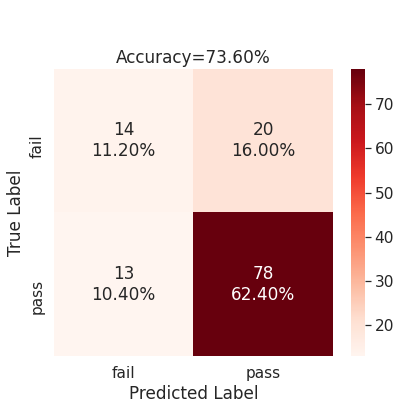

In [33]:
# train XGB
pkl_filename = f"../models/{base_filename}_{SCORING}.pkl"
try :
    # Load Model
    xgb_opt = pickle.load(open(pkl_filename, 'rb'))

except :
    # Train Model
    param_grid = {'learning_rate':Real(1e-2,1e+0,prior='log-uniform'),
                'n_estimators':Integer(100,1000,prior='uniform'),
                'max_depth':Integer(3,10,prior='uniform'),
                'subsample':Real(0.8,1.0,prior='uniform'),
                'gamma':Integer(0,5,prior='uniform')}

    model = XGBClassifier()
    print("Searching best parameters for "+ str(model))
    print("Start Time : "+ str(datetime.now()))
    xgb_opt = BayesSearchCV(estimator=model,
                         search_spaces=param_grid,
                         scoring=SCORING,
                         n_jobs=-1,
                         n_iter=N_ITER,
                         n_points=N_POINTS,
                         random_state=0,
                         cv=CV_FOLDS,
                         verbose=0,
                         refit=True,
                         return_train_score = True)
    # perform bayesian optimization
    print("Start Time : "+ str(datetime.now()))
    xgb_opt.fit(X_train, Y_train)
    print("End Time : "+ str(datetime.now()))
    # Save model
    with open(pkl_filename, 'wb') as file:
        pickle.dump(xgb_opt, file)
    
print(pkl_filename)
print("|----Best Score:" + str(xgb_opt.best_score_))
print("|----Best Parameters: " + str(xgb_opt.best_params_))


# XGB
# confusion matrix
Y_pred = xgb_opt.predict(X_test)
_ = plot_multiclass_confusion_matrix(Y_test, Y_pred, ['fail','pass'])
plt.tight_layout()
plt.savefig(f"../figures/{base_filename}_{SCORING} - Confusion Matrix predict.png")

AUC_ROC = 0.66
Optimal threshold = 0.8488046526908875


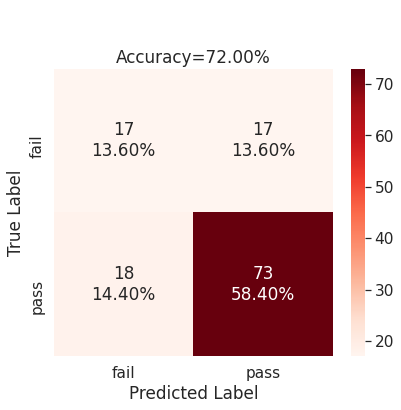

In [34]:
# predict probabilities
probs_xgb = xgb_opt.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification
preds_xgb = probs_xgb[:, 1]
fpr_xgb, tpr_xgb, threshold_xgb = metrics.roc_curve(Y_test, preds_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb,tpr_xgb)
print(f'AUC_ROC = {round(roc_auc_xgb,4)}')
# find optimal threshold
t = threshold_xgb[np.argmax(tpr_xgb - fpr_xgb)]
print(f'Optimal threshold = {t}')
Y_pred = (probs_xgb[:, 1] >= t).astype(int)
_ = plot_multiclass_confusion_matrix(Y_test, Y_pred, ['fail','pass'])
plt.tight_layout()
plt.savefig(f"../figures/{base_filename}_{SCORING} - Confusion Matrix predict_proba.png")

#### Random Forest

In [35]:
base_filename='RandomForestClassifier_'

Searching best parameters for RandomForestClassifier()
Start Time : 2020-12-26 12:04:29.510872
Start Time : 2020-12-26 12:04:29.511503


/home/andrea/anaconda3/envs/student-fail-prediction/lib/python3.8/site-packages/skopt/searchcv.py:529: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **(self.fit_params or {}))


End Time : 2020-12-26 12:04:41.104250
../models/RandomForestClassifier__precision.pkl
|----Best Score:0.9047453703703704
|----Best Parameters: OrderedDict([('class_weight', 'balanced'), ('max_depth', 3), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 316)])


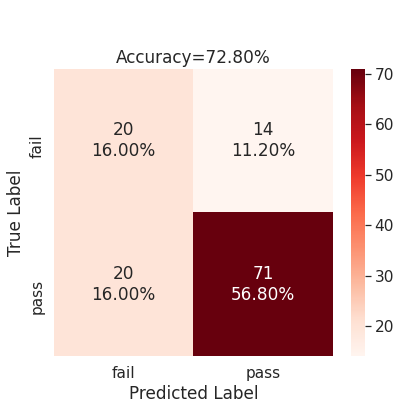

In [36]:
# train RF
pkl_filename = f"../models/{base_filename}_{SCORING}.pkl"
try :
    # Load Model
    rf_opt = pickle.load(open(pkl_filename, 'rb'))

except :
    # Train Model
    param_grid = {'n_estimators':Integer(100,1000,prior='uniform'),
                'max_depth':Integer(3,10,prior='uniform'),
                'min_samples_split':Integer(2,10,prior='uniform'),
                'min_samples_leaf':Integer(1,10,prior='uniform'),  
                'class_weight':Categorical(['balanced'])}

    model = RandomForestClassifier()
    print("Searching best parameters for "+ str(model))
    print("Start Time : "+ str(datetime.now()))
    rf_opt = BayesSearchCV(estimator=model,
                         search_spaces=param_grid,
                         scoring=SCORING,
                         n_jobs=-1,
                         n_iter=N_ITER,
                         n_points=N_POINTS,
                         random_state=0,
                         cv=CV_FOLDS,
                         verbose=0,
                         refit=True,
                         return_train_score = True)
    # perform bayesian optimization
    print("Start Time : "+ str(datetime.now()))
    rf_opt.fit(X_train, Y_train)
    print("End Time : "+ str(datetime.now()))
    # Save model
    with open(pkl_filename, 'wb') as file:
        pickle.dump(rf_opt, file)
    
print(pkl_filename)
print("|----Best Score:" + str(rf_opt.best_score_))
print("|----Best Parameters: " + str(rf_opt.best_params_))

# RF
# confusion matrix
Y_pred = rf_opt.predict(X_test)
_ = plot_multiclass_confusion_matrix(Y_test, Y_pred, ['fail','pass'])
plt.tight_layout()
plt.savefig(f"../figures/{base_filename}_{SCORING} - Confusion Matrix predict.png")

AUC_ROC = 0.7602
Optimal threshold = 0.5432472024963989


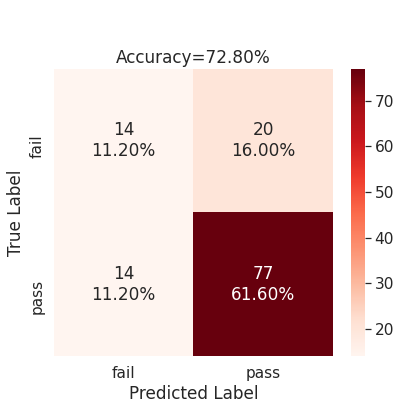

In [37]:
# predict probabilities
probs_rf = rf_opt.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification
preds_rf = probs_rf[:, 1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(Y_test, preds_rf)
roc_auc_rf = metrics.auc(fpr_rf,tpr_rf)
print(f'AUC_ROC = {round(roc_auc_rf,4)}')
# find optimal threshold
t = threshold_rf[np.argmax(tpr_rf - fpr_rf)]
print(f'Optimal threshold = {t}')
Y_pred = (probs_xgb[:, 1] >= t).astype(int)
plot_multiclass_confusion_matrix(Y_test, Y_pred, ['fail','pass'])
plt.tight_layout()
plt.savefig(f"../figures/{base_filename}_{SCORING} - Confusion Matrix predict_proba.png")

### Comparing ROC - AUC

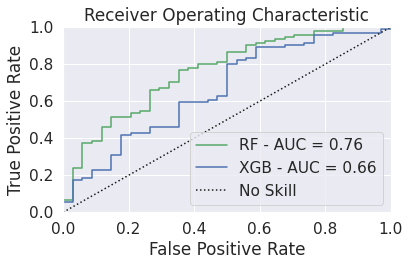

In [38]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'g', label = f'RF - AUC = {round(roc_auc_rf,3)}')
plt.plot(fpr_xgb, tpr_xgb, 'b', label = f'XGB - AUC = {round(roc_auc_xgb,3)}')
plt.plot([0, 1], [0, 1],'k:', label='No Skill')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.tight_layout()
plt.savefig(f"../figures/Comparison ROC - {SCORING}.png")
plt.show()

## Model Selection

In [39]:
filename = '../models/RandomForestClassifier__precision.pkl'
model = pickle.load(open('../models/RandomForestClassifier__precision.pkl', 'rb'))
print(f'Filename : {filename}')
print(f'Model type : {type(model.estimator)}')
print(f'Model Parameters : {model.best_params_}')
print(f'CV Score : {model.best_score_}')
print(f'Test Score : {model.score(X_test, Y_test)}')

with open("../models/Model Summary.txt", "w") as f:
    print(f'Filename : {filename}', file=f)
    print(f'Model type : {type(model.estimator)}', file=f)
    print(f'Model Parameters : {model.best_params_}', file=f)
    print(f'CV Score : {model.best_score_}', file=f)
    print(f'Test Score : {model.score(X_test, Y_test)}', file=f)

Filename : ../models/RandomForestClassifier__precision.pkl
Model type : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model Parameters : OrderedDict([('class_weight', 'balanced'), ('max_depth', 3), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 316)])
CV Score : 0.9047453703703704
Test Score : 0.8352941176470589
